**Problem Definition:**

Given clinical parameters about a patient, can we predict whether or not they have heart disease?


**Data Dictionary:**

age: age                                                        (integer)

sex: sex                                                        (categorical)

cp: chest pain type                                             (categorical)

trestbps: resting blood pressure (on admission to the hospital) (integer)

chol: serum cholestoral                                         (integer)

fbs: fasting blood sugar                                        (categorical)

thalach: maximum heart rate achieved                            (integer)

exang: exercise induced angina                                  (categorical)

oldpeak: ST depression induced by exercise relative to rest     (integer)

slope: slope                                                    (categorical)

ca: number of major vessels (0-3) colored by flourosopy         (integer)



**Evaluation:**

If we can achieve a >= 95% accuracy at predicting whether or not the patient has a heart disease, the model can be considered satisfactory.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_csv('datasets/heart-disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [16]:
df.isna().values.sum(), df.shape

(0, (303, 14))

<Axes: xlabel='target'>

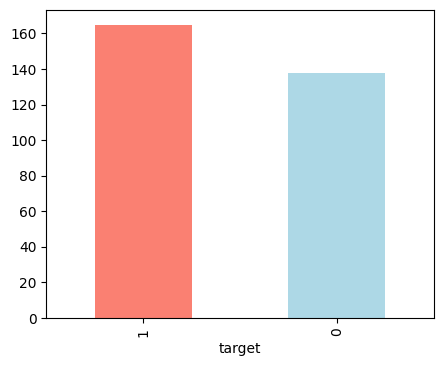

In [14]:
df.target.value_counts().plot(kind="bar", color=['salmon','lightblue'], figsize=(5,4))

In [17]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


**Heart disease frequency according to sex**

In [3]:
df.sex.value_counts()
# 1 = male
# 0 = female

sex
1    207
0     96
Name: count, dtype: int64

In [4]:
pd.crosstab(df.target, df.sex)
# 1 = the patient tested positive
# With this data alone we can already infere that women are more likely (about 70%) to test positive

sex,0,1
target,,
0,24,114
1,72,93


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

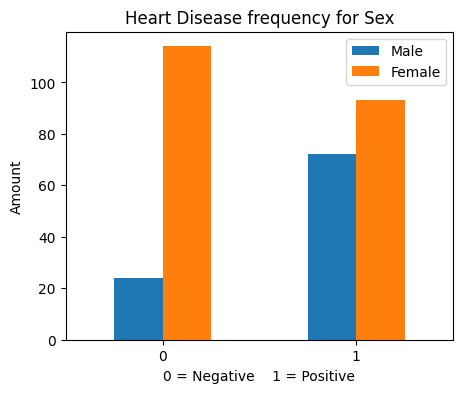

In [11]:
pd.crosstab(df.target, df.sex).plot(kind="bar", figsize=(5,4))
plt.title("Heart Disease frequency for Sex")
plt.xlabel("0 = Negative    1 = Positive")
plt.ylabel("Amount")
plt.legend(["Male","Female"])
plt.xticks(rotation=0)

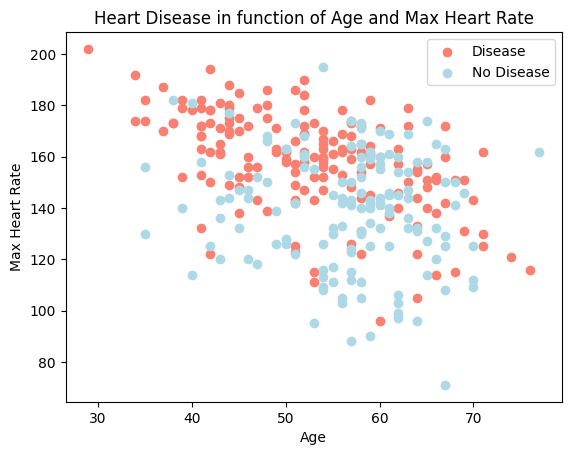

In [5]:
# Age vs Heart Disease

plt.scatter(df.age[df.target == 1],
            df.thalach[df.target == 1],
            c="salmon")

plt.scatter(df.age[df.target == 0],
            df.thalach[df.target == 0],
            c="lightblue")

plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Disease","No Disease"])

<Axes: ylabel='Frequency'>

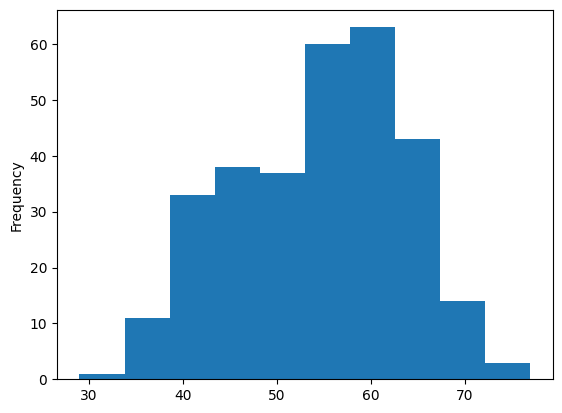

In [6]:
# Check distribution of the age data
df.age.plot.hist()

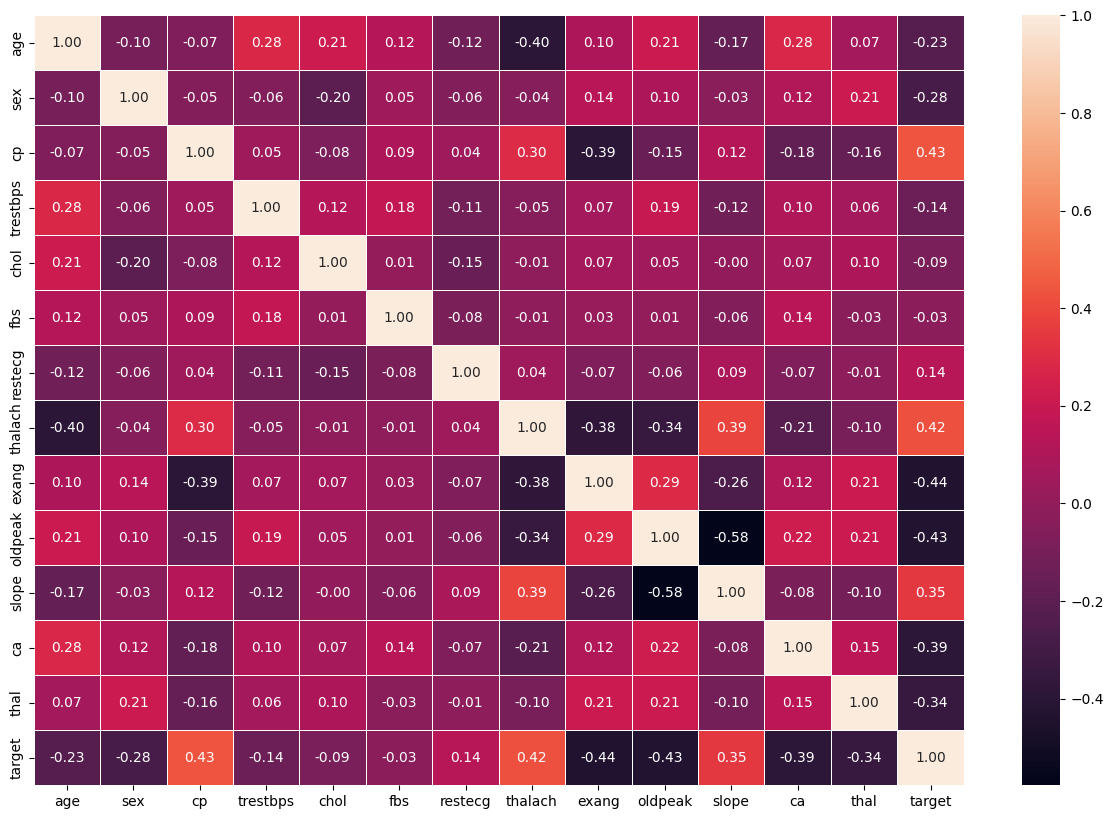

In [13]:
# Correlation Matrix
corr_matrix = df.corr()

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f")

_________________________
**Modelling**

We are going to try 3 different models:

- Logisitc Regression
- K-Nearest Neighbours Classifier
- Random Forest Classifier

In [4]:
np.random.seed(42)

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

***Model Comparison***

In [8]:
models = {"Logistic Regerssion": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    
    model_scores = {}
    
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        #Evaluate the model and append the score to model_scores
        model_scores[name] = model.score(X_test,y_test)
        
    return model_scores

In [9]:
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
model_scores

{'Logistic Regerssion': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918}

<Axes: >

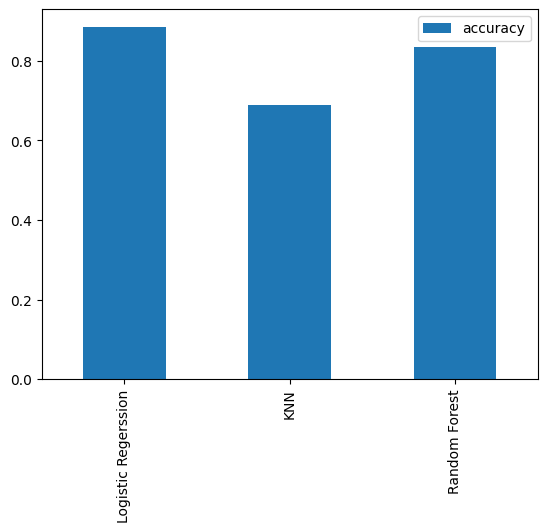

In [11]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar()

***Hyperparameter Tuning***

In [17]:
# KNN

train_scores = []
test_scores = []

# creating a list of different values for n_neighbours
neighbours = range(1,21)
# set up KNN instance
knn = KNeighborsClassifier()

# loop thruough different n_neighbours 
for i in neighbours:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(X_train,y_train)
    
    # Update the training score list
    train_scores.append(knn.score(X_train,y_train))
    
    # Update the test score list
    test_scores.append(knn.score(X_test,y_test))

Maximum KNN score on the test data: 0.7540983606557377


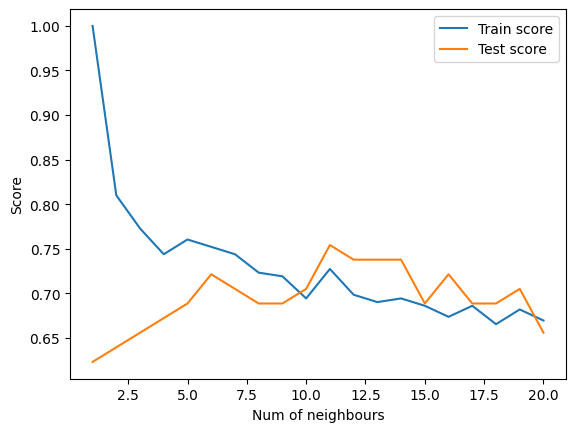

In [23]:
plt.plot(neighbours, train_scores, label="Train score")
plt.plot(neighbours, test_scores, label="Test score")
plt.xlabel("Num of neighbours")
plt.ylabel("Score")
plt.legend()

print("Maximum KNN score on the test data:", max(test_scores))

***Hyperparameter Tuning***

In [9]:
# Hyperparameters for Logistic Regression
log_reg_params = {"C": np.logspace(-4, 4, 20),
                  "solver": ["liblinear"]}


# Hyperparameters for Random Forest Classifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None,3,5,10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2)}

In [5]:
np.random.seed(42)

# Random hyperparameter search for Logistic Regression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_params,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [6]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [7]:
rs_log_reg.score(X_test,y_test)

0.8852459016393442

In [10]:
np.random.seed(42)

# Random hyperparameter search for Random Forest Classifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

rs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [11]:
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [12]:
rs_rf.score(X_test, y_test)

0.8688524590163934

Since the Logistic Regression model provides the best scores so far, we shall try to improve them again using GridSearchCV.

In [5]:
log_reg_grid = {"C": np.logspace(-4,4,20),
                "solver": ["liblinear"]}

# Grid hyperparamter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [6]:
gs_log_reg.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [7]:
gs_log_reg.score(X_test, y_test)

0.8852459016393442

***Model Evaluation***

- ROC curve and AUC score
- Confusion matrix
- Classification report
- Precision
- Recall
- F1-score

In [ ]:
# Plot ROC cruve and calculate
roc_curve(gs_log_reg, X_test, y_test)

In [10]:
# Confusion Matrix
y_preds = gs_log_reg.predict(X_test)
print(confusion_matrix(y_test, y_preds))

[[25  4]
 [ 3 29]]


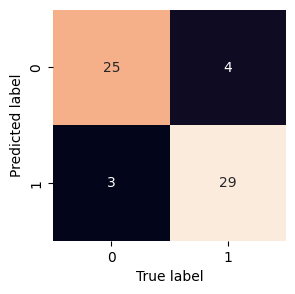

In [11]:
def plot_conf_mat(y_test,y_preds):
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
plot_conf_mat(y_test,y_preds)

In [12]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



In [13]:
# Calculate evaluation metrics using Cross-Validation
gs_log_reg.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [14]:
clf = LogisticRegression(C=0.23357214690901212,
                         solver='liblinear')

In [17]:
# Accuracy
cv_acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
np.mean(cv_acc)

0.8479781420765027

In [18]:
# Precision
cv_precision = cross_val_score(clf, X, y, cv=5, scoring="precision")
np.mean(cv_precision)

0.8215873015873015

In [19]:
# Recall 
cv_recall = cross_val_score(clf, X, y, cv=5, scoring="recall")
np.mean(cv_recall)

0.9272727272727274

In [22]:
# F1-score
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring="f1")
np.mean(cv_f1)

0.8705403543192143

<Axes: title={'center': 'Cross-validated classification metrics'}>

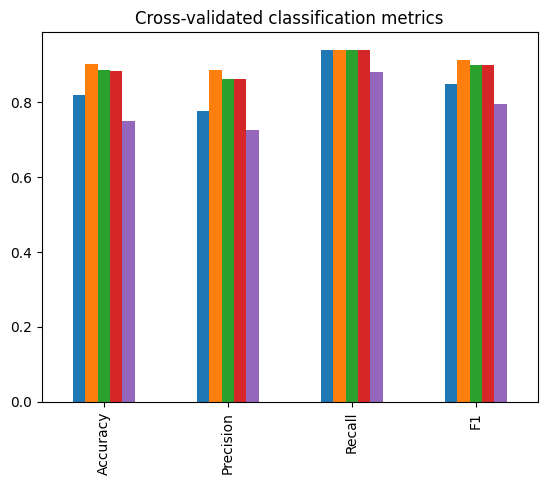

In [27]:
cv_metrics = pd.DataFrame({"Accuracy":cv_acc,
                           "Precision":cv_precision,
                           "Recall":cv_recall,
                           "F1":cv_f1})
cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                      legend=False)

______
**Feature Importance**

In [29]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [31]:
clf = LogisticRegression(C=0.23357214690901212,
                         solver='liblinear')
clf.fit(X_train,y_train)

clf.coef_

array([[ 0.00369922, -0.9042409 ,  0.67472826, -0.0116134 , -0.00170364,
         0.04787688,  0.33490198,  0.02472938, -0.63120406, -0.5759095 ,
         0.47095141, -0.65165348, -0.69984208]])

In [32]:
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))

{'age': 0.0036992207735222936,
 'sex': -0.9042409027676933,
 'cp': 0.6747282591013247,
 'trestbps': -0.011613401311995881,
 'chol': -0.001703643974904055,
 'fbs': 0.04787688089306608,
 'restecg': 0.3349019821325941,
 'thalach': 0.024729382907772574,
 'exang': -0.6312040609811942,
 'oldpeak': -0.5759095019287949,
 'slope': 0.4709514064291035,
 'ca': -0.6516534774104941,
 'thal': -0.6998420760932893}

<Axes: title={'center': 'Feature Importance'}>

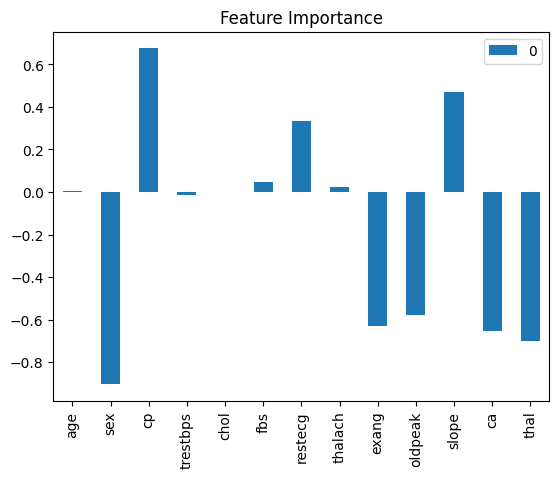

In [34]:
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend="False")

In [35]:
pd.crosstab(df["sex"],df["target"])

target,0,1
sex,,
0,24,72
1,114,93
